In [ ]:
import os

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import albumentations as A

from gan import *
from gan_utils import *
from visualization import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Need functions

In [ ]:
def get_data(input_path, scene, size=(256, 256)):
    path = os.path.join(input_path, scene)
    images, names = [], []

    for image in sorted(os.listdir(path)):
        names.append(int(image[:-4]))

    names.sort()
    
    for i in range(len(names)):
        images.append(imread(os.path.join(path, str(names[i]) + '.jpg')))

    out = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]

    print(f'loaded {len(out)} {scene}')
    return np.array(out, np.float32)

## Choose model (gan or baseline)

In [ ]:
model_name = input('model: ')

model: gan


## Getting and Preprocessing Data

In [ ]:
input_path = '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/'

tumor = get_data(input_path, scene='tumor_train')
clean = get_data(input_path, scene='clean_train')

loaded 1029 tumor_train
loaded 1029 clean_train


In [ ]:
print(f'we have {len(tumor)} tumor images and {len(clean)} clean images')

we have 1029 tumor images and 1029 clean images


## Augmentation

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=0.5),
                       A.RandomBrightnessContrast(p=0.8),
                       A.Rotate(limit=(-90, 90)),
                       A.VerticalFlip(p=0.5),
                       A.ChannelShuffle(),
                       A.RandomRotate90()])

In [ ]:
images = np.concatenate((tumor, clean), axis=0)
aug_images = []

for i in range(len(images)):

    transformed = transform(image=images[i])
    aug_images.append(transformed['image'])

In [ ]:
images = np.concatenate((images, aug_images), axis=0)

In [ ]:
print(f'after augmentation we have {len(images)} ({len(tumor)} * 2 + {len(clean)} * 2) images')

after augmentation we have 4116 (1029 * 2 + 1029 * 2) images


In [ ]:
del tumor, clean, aug_images

## Get Pairs LR-HR

In [ ]:
LR, HR = transform_images(images)

In [ ]:
del images

## Data Visualization

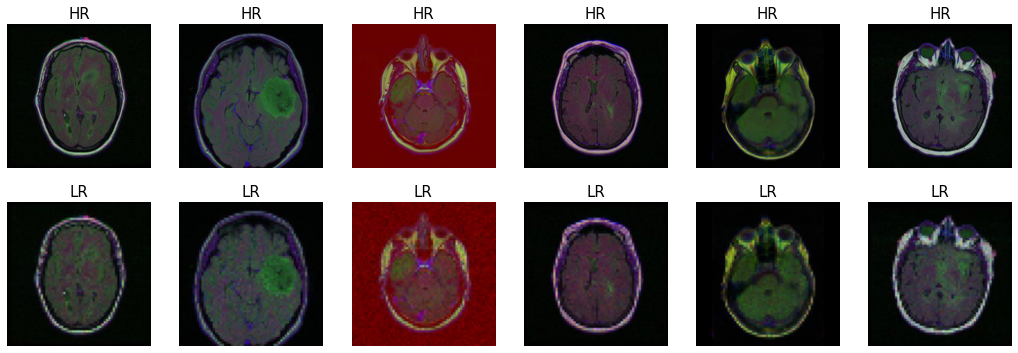

In [ ]:
plot_images(LR, HR)

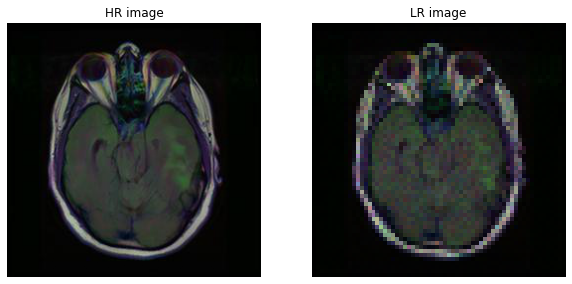

In [ ]:
num = 123
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('HR image', fontdict={'fontsize': 12})
plt.imshow(HR[num])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('LR image', fontdict={'fontsize': 12})
plt.imshow(LR[num])

## Model Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [ ]:
gen, disc = trained_gan(HR, LR, batch_size=32, epochs=10, lr_gan=0.0001, lr_disc=0.0001)

torch.save(gen.state_dict(), '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/gan/gan.torch')

In [ ]:
del HR, LR 

## Generate Test Images

In [ ]:
gen = Generator().to(device)
gen.load_state_dict(torch.load('/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/test_models/gan/gan.torch'))

<All keys matched successfully>

In [ ]:
input_path = '/content/gdrive/My Drive/ВКР/ВКР (4 курс)/datasets/'

tumor = get_data(input_path, scene='tumor_test')
clean = get_data(input_path, scene='clean_test')

tumor_L, tumor_H = transform_images(tumor)
clean_L, clean_H = transform_images(clean)

loaded 344 tumor_test
loaded 344 clean_test


In [ ]:
tumor_GT, tumor_LR, tumor_HR = [], [], []

for i in range(len(tumor_L)):
    HR_gt, LR_images, HR_gen = test(tumor_H[i], tumor_L[i], gen)
    tumor_GT.append(HR_gt)
    tumor_LR.append(LR_images)
    tumor_HR.append(HR_gen)

In [ ]:
clean_GT, clean_LR, clean_HR = [], [], []

for i in range(len(clean_L)):
    HR_gt, LR_images, HR_gen = test(clean_H[i], clean_L[i], gen)
    clean_GT.append(HR_gt)
    clean_LR.append(LR_images)
    clean_HR.append(HR_gen)

In [ ]:
save_images(tumor_HR, tumor_GT, tumor_LR, test_model='gan', mode='tumor')
save_images(clean_HR, clean_GT, clean_LR, test_model='gan', mode='clean')

## Results visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


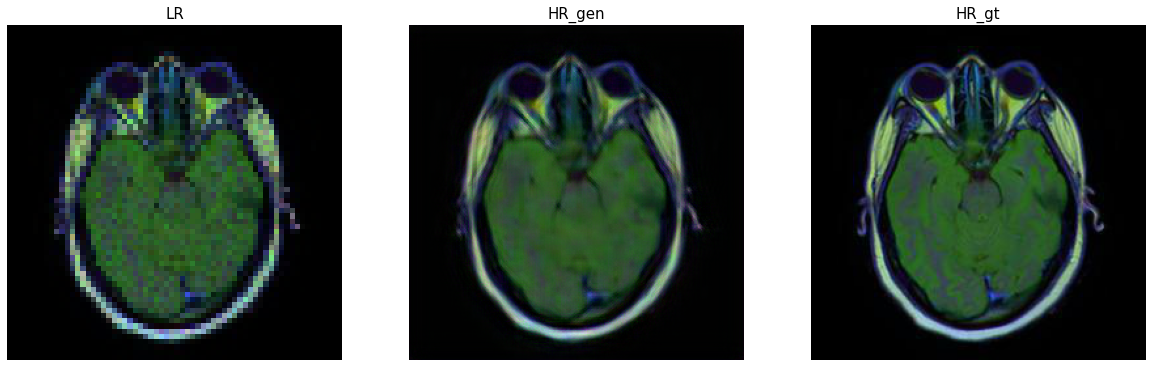

In [ ]:
plot_results(clean_LR, clean_HR, clean_GT, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


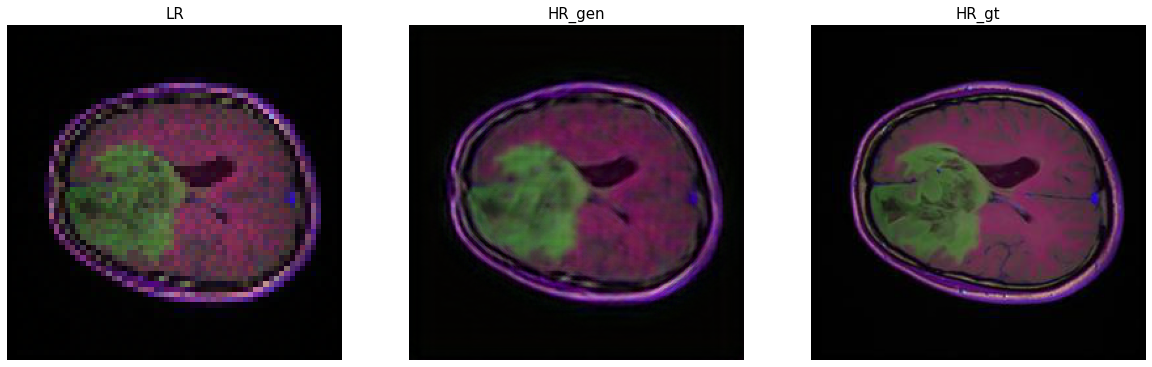

In [ ]:
plot_results(tumor_LR, tumor_HR, tumor_GT, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


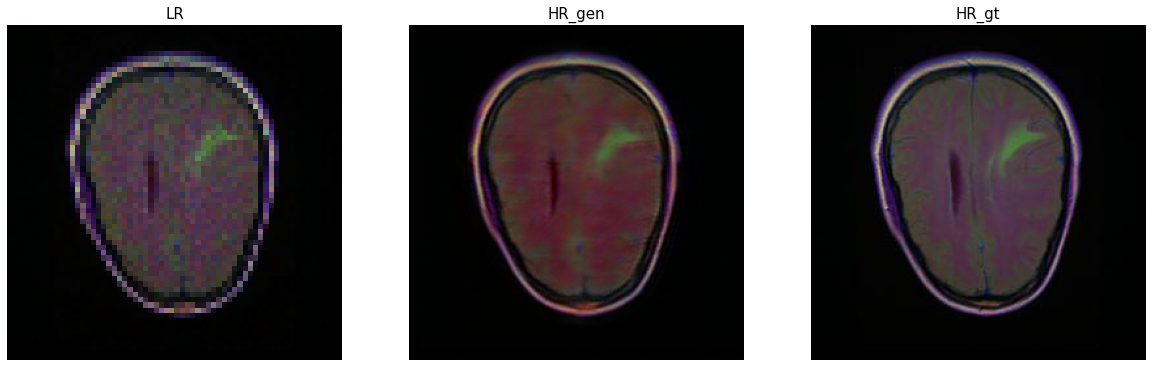

In [ ]:
plot_results(tumor_LR, tumor_HR, tumor_GT, 78)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


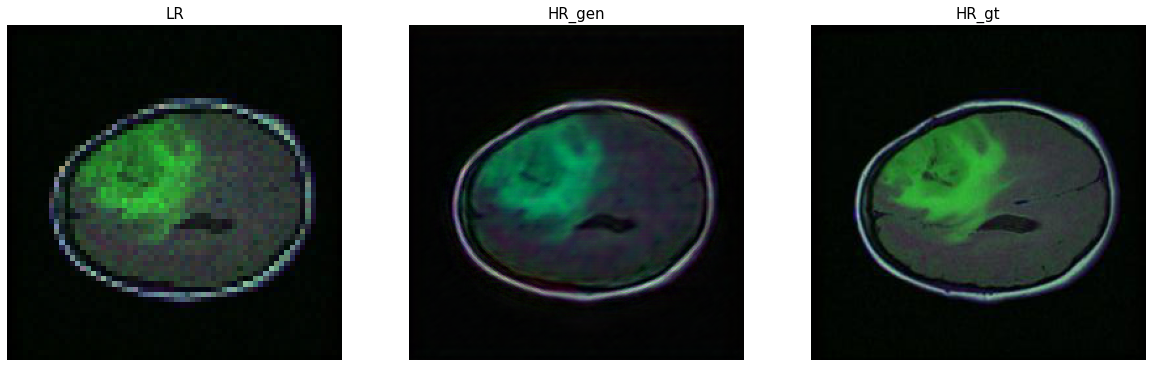

In [ ]:
plot_results(tumor_LR, tumor_HR, tumor_GT, 354)